In [1]:
import numpy as np
import pandas as pd
import GPy
import time
import sys
import os
import pdb
import matplotlib.pyplot as plt

from context import aep
from context import load_data
from context import delete_blocks
from context import start_df
from context import save_df
from context import metrics
from thesis_work.plots import GP_figures
from thesis_work.plots import SGP_figures
from thesis_work.plots import DGP_figures

from baseline_models import full_GP_reg
from baseline_models import sparse_GP_reg
from aep_config import cont_optimization
from aep_config import aep_DGP_reg

default_dict = {'M': 40, 'hidden_size': [2], 
			'optimizer':'adam', 'max_it':100,
            'MB': 250, 'lr': 0.01, 'fixed_hyp': []}
os.getcwd()
%matplotlib notebook

Dataset size:  2500  Test size:  1000.0
Training:  500
Removing blocks... [0.75, 1.15, 1.2, 1.6, 3.5, 4.25, 4.3, 5.2, 7, 11]
Removing blocks... [-1, 0.75, 1.15, 1.2, 1.6, 3.5, 4.25, 4.3, 5.2, 11]


<IPython.core.display.Javascript object>


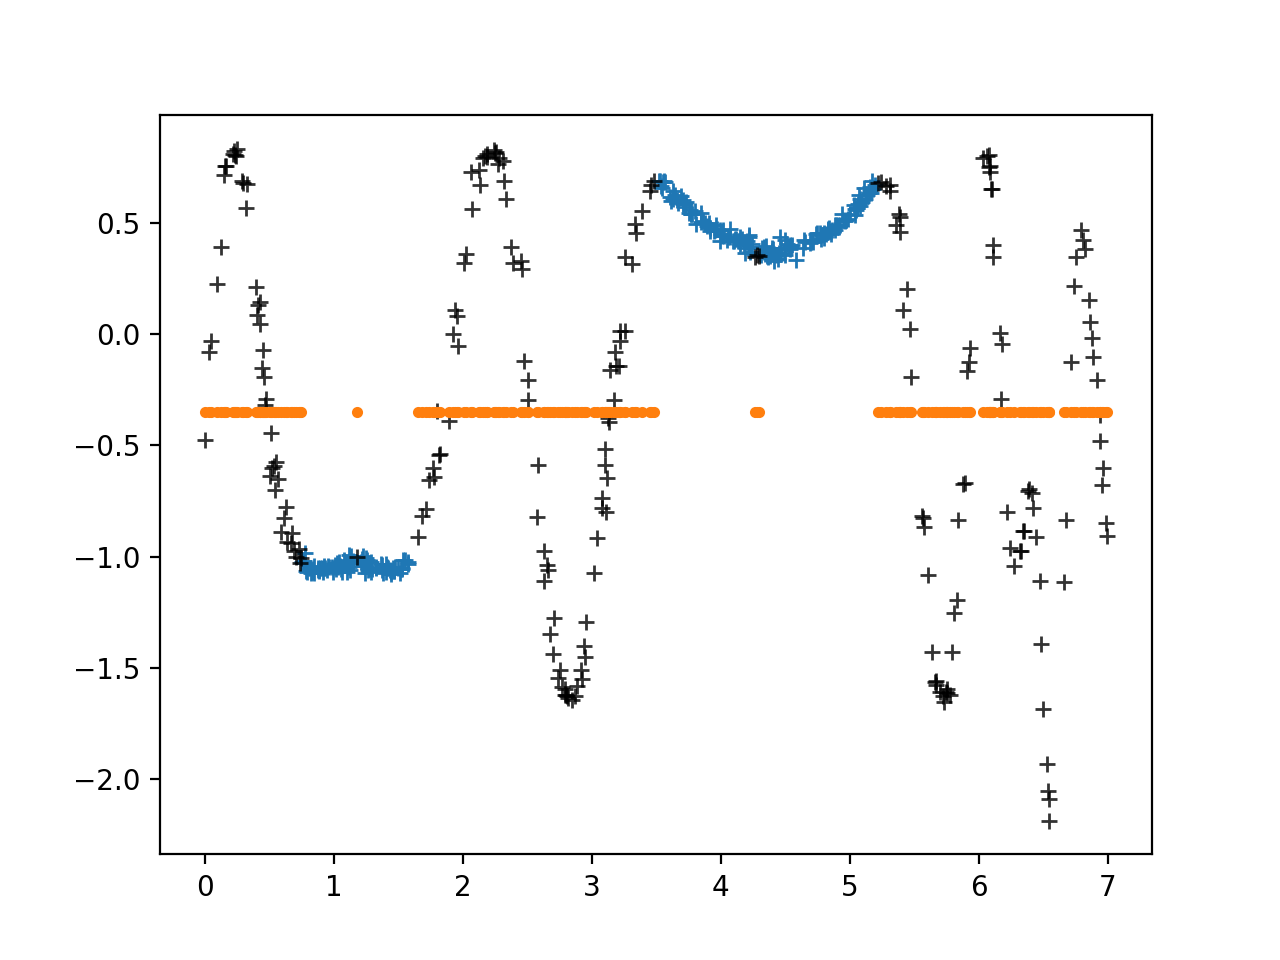

In [68]:
path = 'data/sample_1.txt'
X_train, y_train, X_test, y_test = load_data(path, N_train=500, test=0.4, norm_out=False)
# X_test, y_test = delete_blocks(X_test, y_test,
#                                intervals=[3.5,6])
X_train, y_train = delete_blocks(X_train, y_train,
                               intervals=[0.75,1.15,1.20,1.6,3.5, 4.25,4.30,5.2,7,11])
X_test, y_test = delete_blocks(X_test, y_test,
                               intervals=[-1,0.75,1.15,1.2,1.6,3.5, 4.25,4.3,5.2,11])
plt.figure()
plt.plot(X_test, y_test, '+')
plt.plot(X_train, y_train, '+k', alpha=0.8)
plt.plot(X_train, y_train.mean()*np.ones(y_train.shape),'.')
plt.show()

Create DGP model and optimize ...
Optimise with fixed:  ['zu_0', 'eta2_0']
SGP greedy initialisation
Perform sparse GP regression
theta1 not positive definite
theta1 not positive definite
sf_0
sn
ls_0
eta2_0
zu_0
eta1_R_0
iter 0 	 obj 7.678
iter 50 	 obj 1.330
iter 100 	 obj 0.613
iter 150 	 obj 0.322
iter 200 	 obj 0.209
iter 250 	 obj 0.165
iter 300 	 obj 0.143
iter 350 	 obj 0.128
iter 400 	 obj 0.115
iter 450 	 obj 0.106
iter 500 	 obj 0.098
iter 550 	 obj 0.091
iter 600 	 obj 0.086
iter 650 	 obj 0.081
iter 700 	 obj 0.076
iter 750 	 obj 0.072
iter 800 	 obj 0.068
iter 850 	 obj 0.064
iter 900 	 obj 0.060
iter 950 	 obj 0.054
Test MSE= 0.145, NLL= 0.331, SN= 0.131


<IPython.core.display.Javascript object>


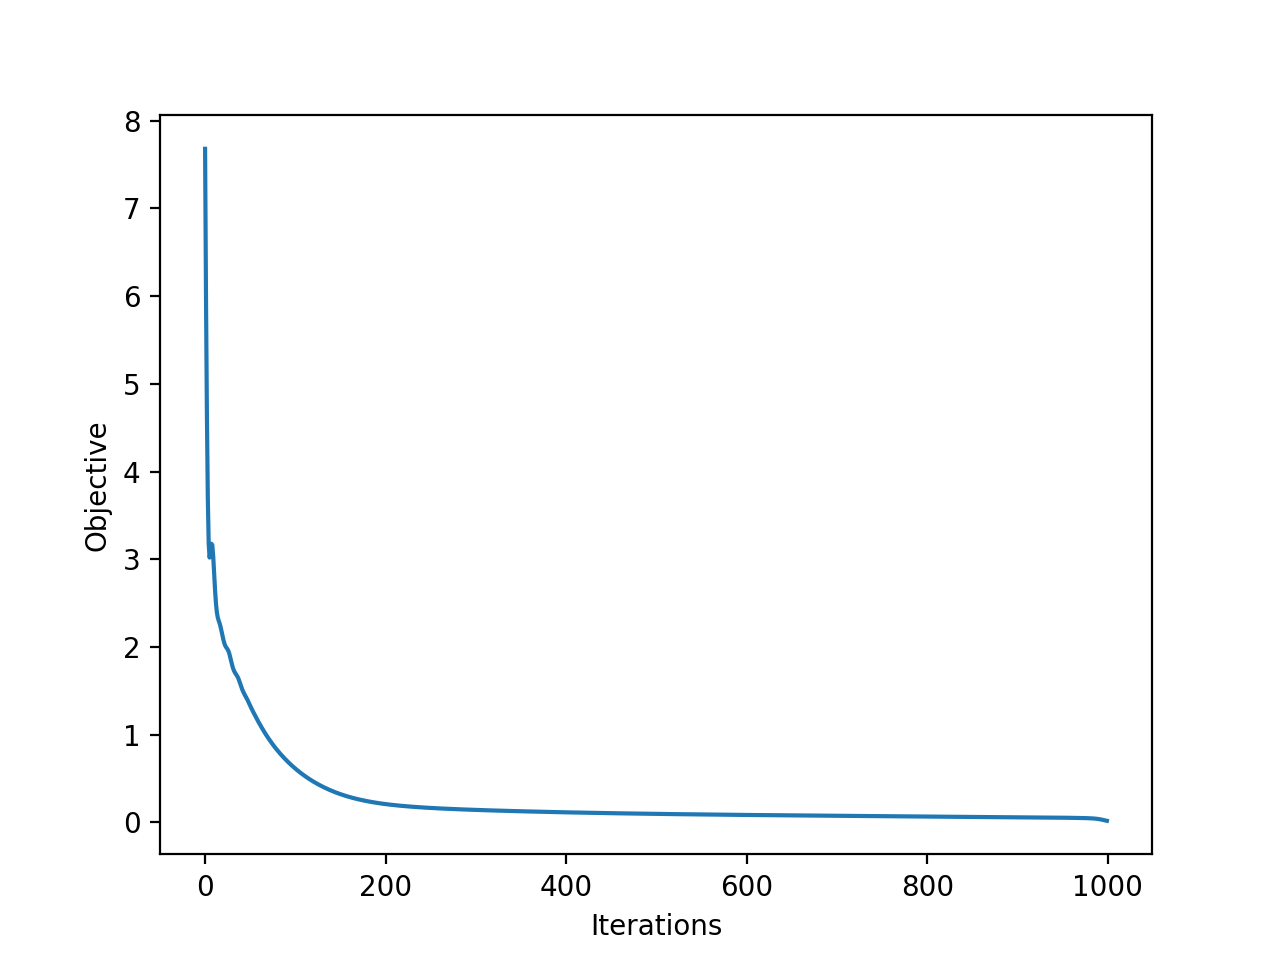

In [69]:
N_train = X_train.shape[0]
# ['zu_0', 'sf_0', 'ls_0', 'eta2_0', 'eta1_R_0']
config_dict = {'M': 25, 'hidden_size': [2], 
			'optimizer':'adam', 'max_it':1000,
            'MB': 250, 'lr': 0.01, 'fixed_hyp': ['zu_0', 'eta2_0'],
            'init_type':'greedy'}

model, df, costs = aep_DGP_reg(X_train, y_train, X_test, y_test, 
				conf_dict= config_dict,
				return_cost=True)
fig0 = DGP_figures(model,conf_dict=config_dict).plot_cost(costs)
plt.show()

In [70]:
config_dict2 = {'M':25, 'hidden_size': [2], 
			'optimizer':'adam', 'max_it':1000,
            'MB': 250, 'lr': 0.01, 'fixed_hyp': [],
            'init_type':'greedy'}
model, df = cont_optimization(model, X_test, y_test, conf_dict=config_dict2,
                              new_max_it=1000, return_cost=False)

Optimise with fixed:  []
iter 0 	 obj 0.017
iter 50 	 obj -0.046
iter 100 	 obj -0.081
iter 150 	 obj -0.109
iter 200 	 obj -0.137
iter 250 	 obj -0.160
iter 300 	 obj -0.177
iter 350 	 obj -0.190
iter 400 	 obj -0.200
iter 450 	 obj -0.209
iter 500 	 obj -0.219
iter 550 	 obj -0.227
iter 600 	 obj -0.233
iter 650 	 obj -0.239
iter 700 	 obj -0.245
iter 750 	 obj -0.250
iter 800 	 obj -0.255
iter 850 	 obj -0.259
iter 900 	 obj -0.261
iter 950 	 obj -0.264
Test MSE= 0.051, NLL= 0.206, SN= 0.097


<IPython.core.display.Javascript object>


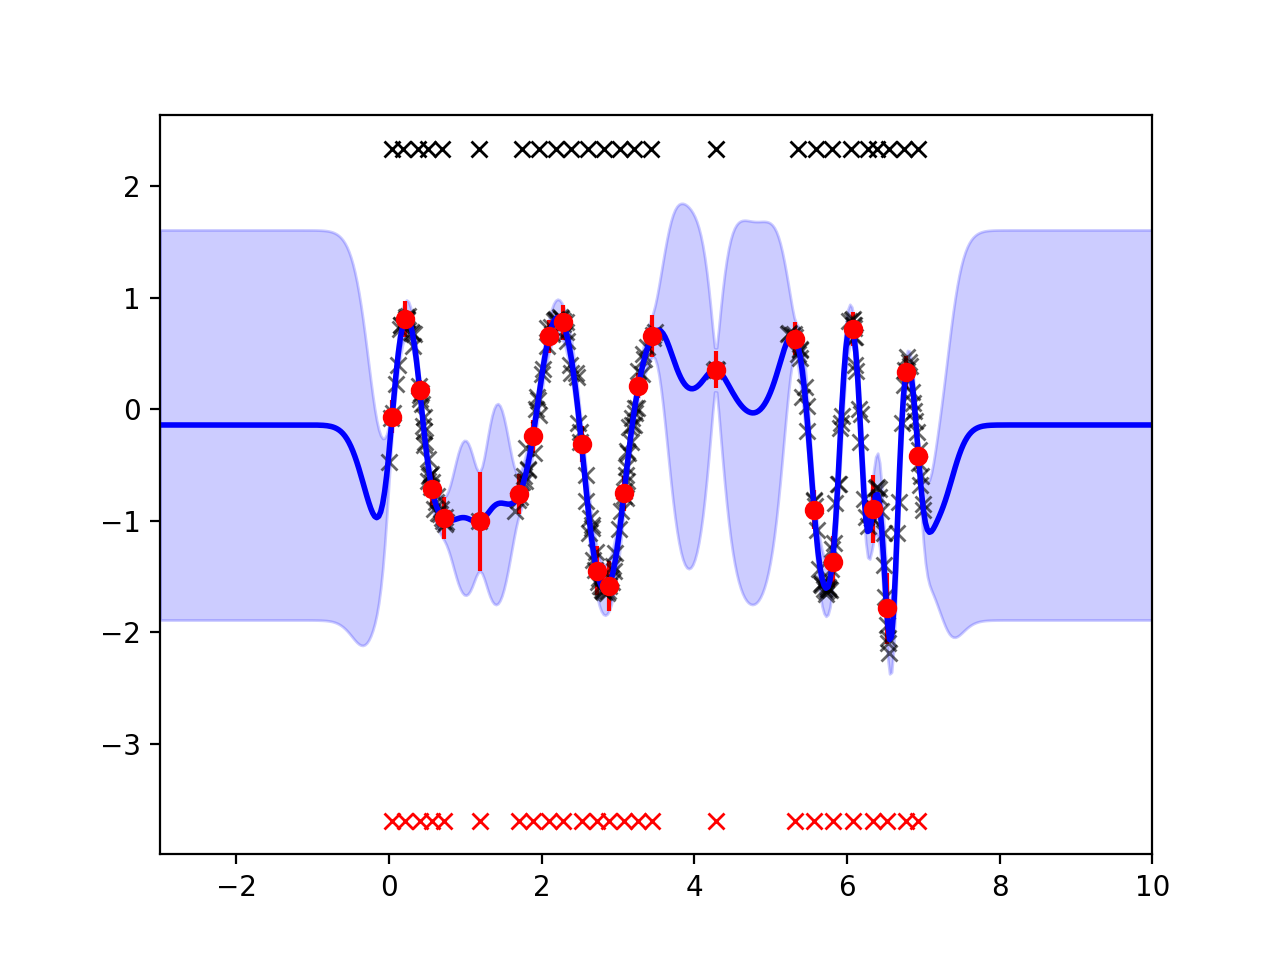

SGP greedy initialisation
Perform sparse GP regression
theta1 not positive definite
theta1 not positive definite
sf_0
sn
ls_0
eta2_0
zu_0
eta1_R_0


In [71]:
%matplotlib notebook
# fig3 = DGP_figures(model, conf_dict=config_dict).plot_in_h()
# fig4 = DGP_figures(model, conf_dict=config_dict).plot_hidden()
fig5 = DGP_figures(model, conf_dict=config_dict).plot()
plt.show()

create full GP model and optimize ...
Test MSE =0.068, NLL =0.302


<IPython.core.display.Javascript object>


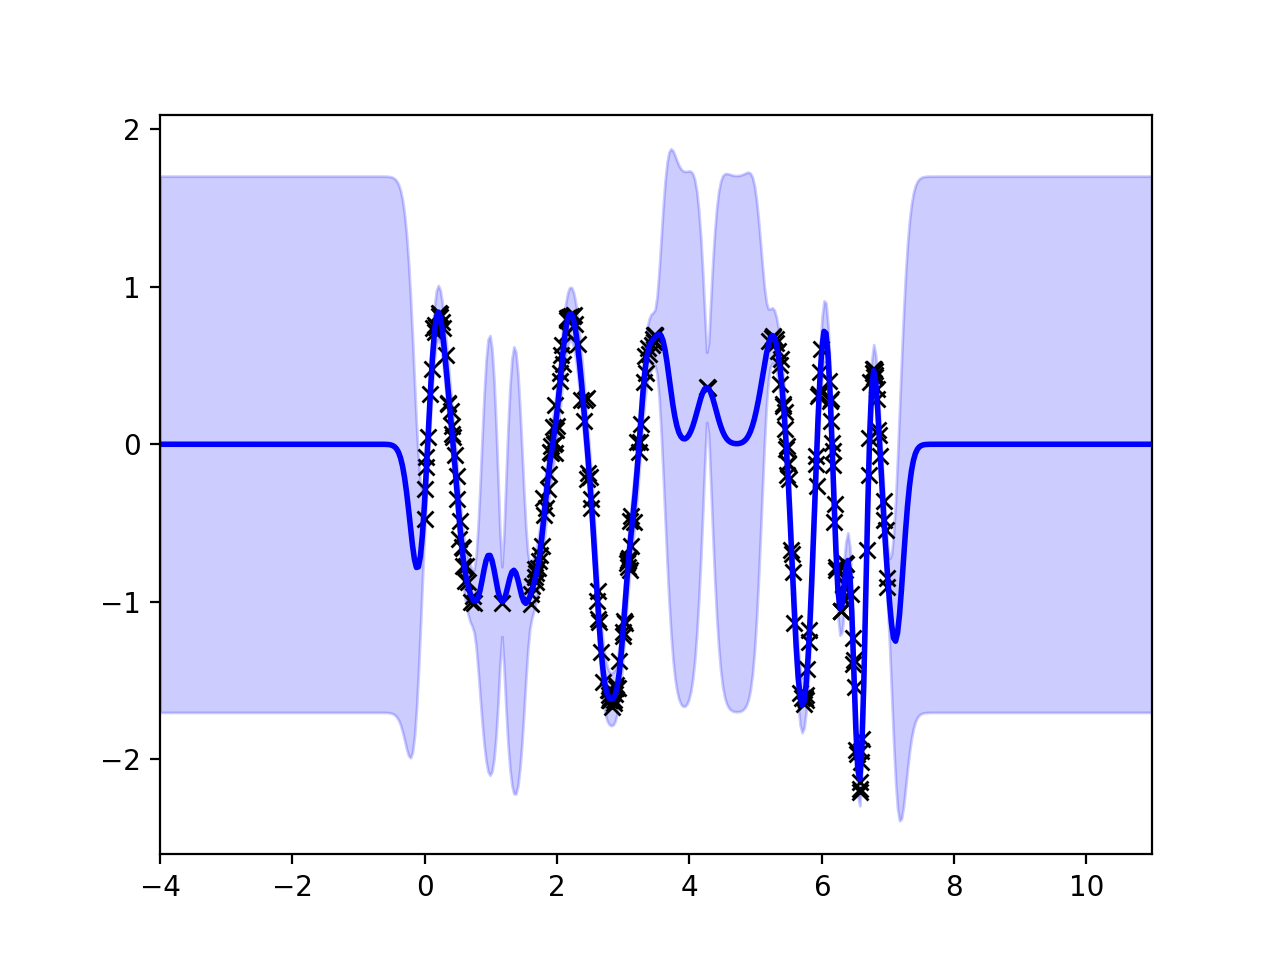

In [31]:
model_gp, df = full_GP_reg(X_train, y_train, X_test, y_test)
fig = GP_figures(model_gp).plot()
plt.show()

0.20593452563
0.202968196429


<IPython.core.display.Javascript object>


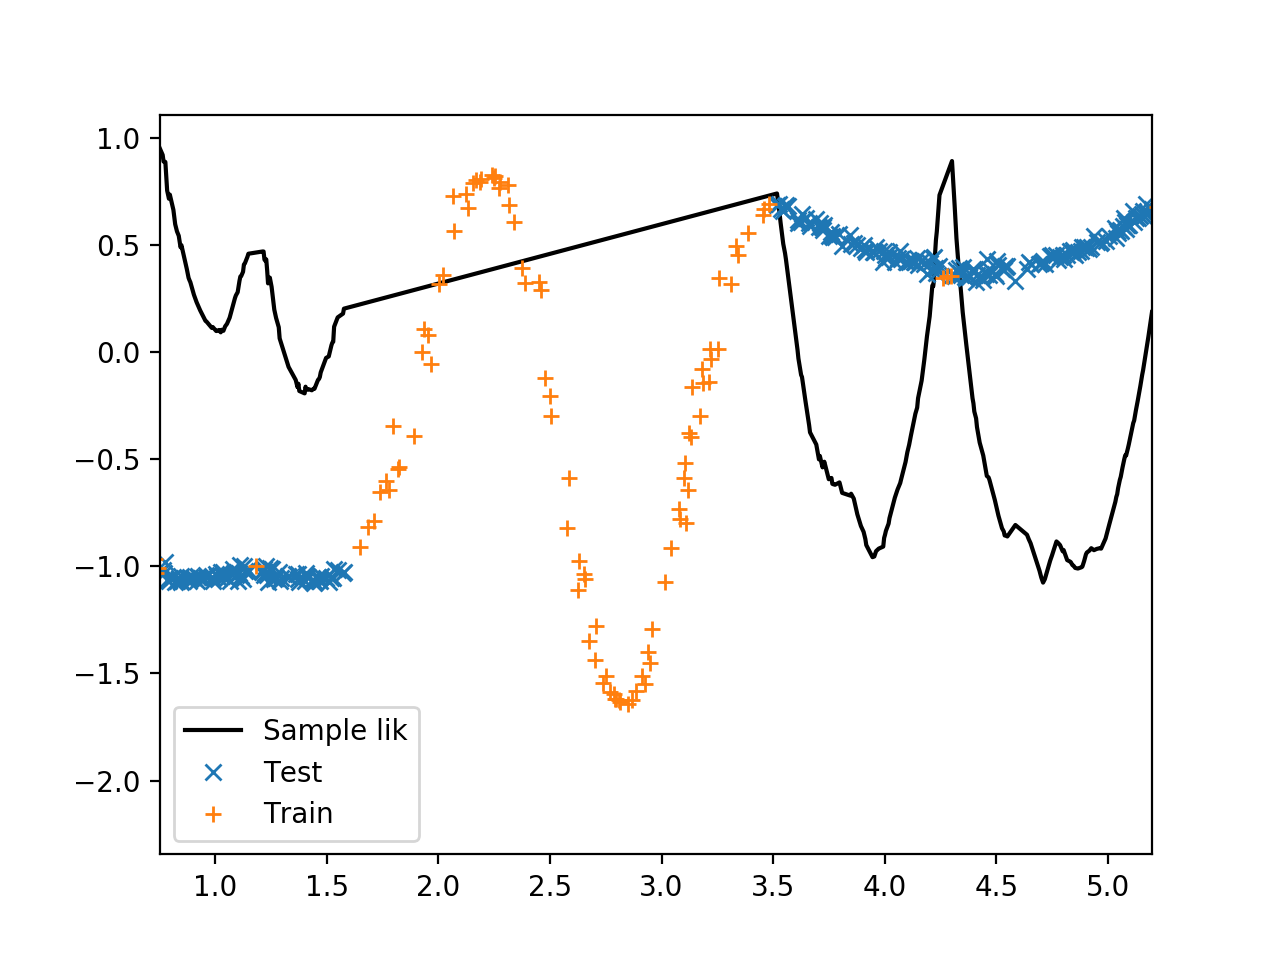

In [72]:
print metrics.METRICS(y_test, model.predict_y(X_test)[0],model.predict_y(X_test)[1]).nll()
score, ho_liks = metrics.ho_nll_samples(model, X_test, y_test, N_samples=1000)
print score
# print metrics.nll_MLE_samples(model, X_test, y_test, N_samples=1000)
list1 = X_test
list2 = ho_liks
from operator import itemgetter
a = [list(x) for x in zip(*sorted(zip(list1, list2), key=itemgetter(0)))]

plt.figure()
plt.plot(a[0], a[1], 'k-', label='Sample lik')

plt.plot(X_test, y_test, 'x',label='Test')
plt.plot(X_train, y_train, '+',label='Train' )
plt.xlim([np.min(X_test),np.max(X_test)] )
plt.legend()
plt.show()

create SGP model and optimize ...
Test MSE =0.055, NLL =-0.048


<IPython.core.display.Javascript object>


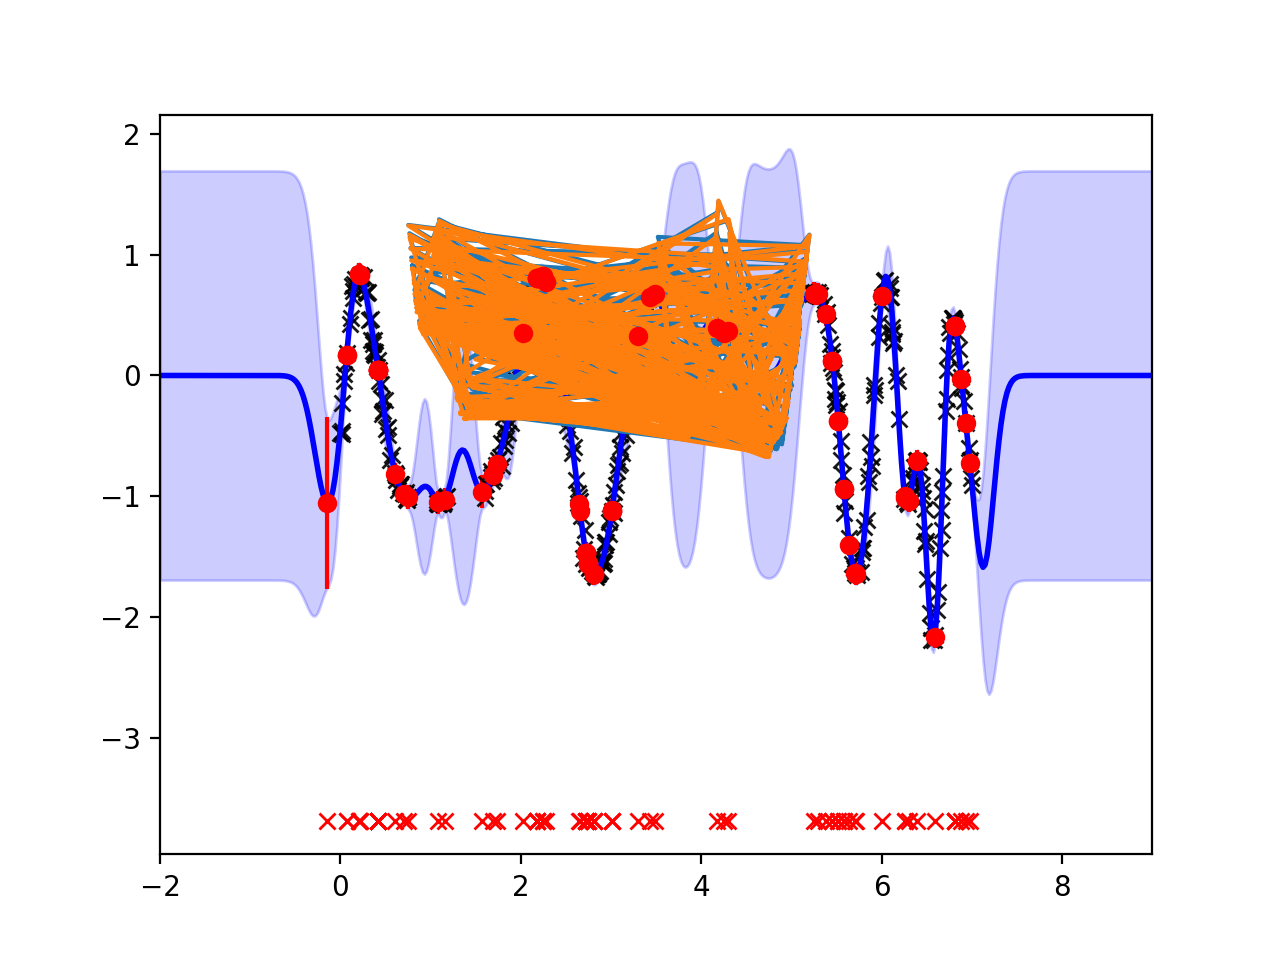

In [24]:
model_sgp, df = sparse_GP_reg(X_train, y_train, X_test, y_test, M=75)
fig = SGP_figures(model_sgp).plot()
plt.show()

In [52]:
model_sgp.inference_method=GPy.inference.latent_function_inference.FITC()
model_sgp.optimize()


<IPython.core.display.Javascript object>


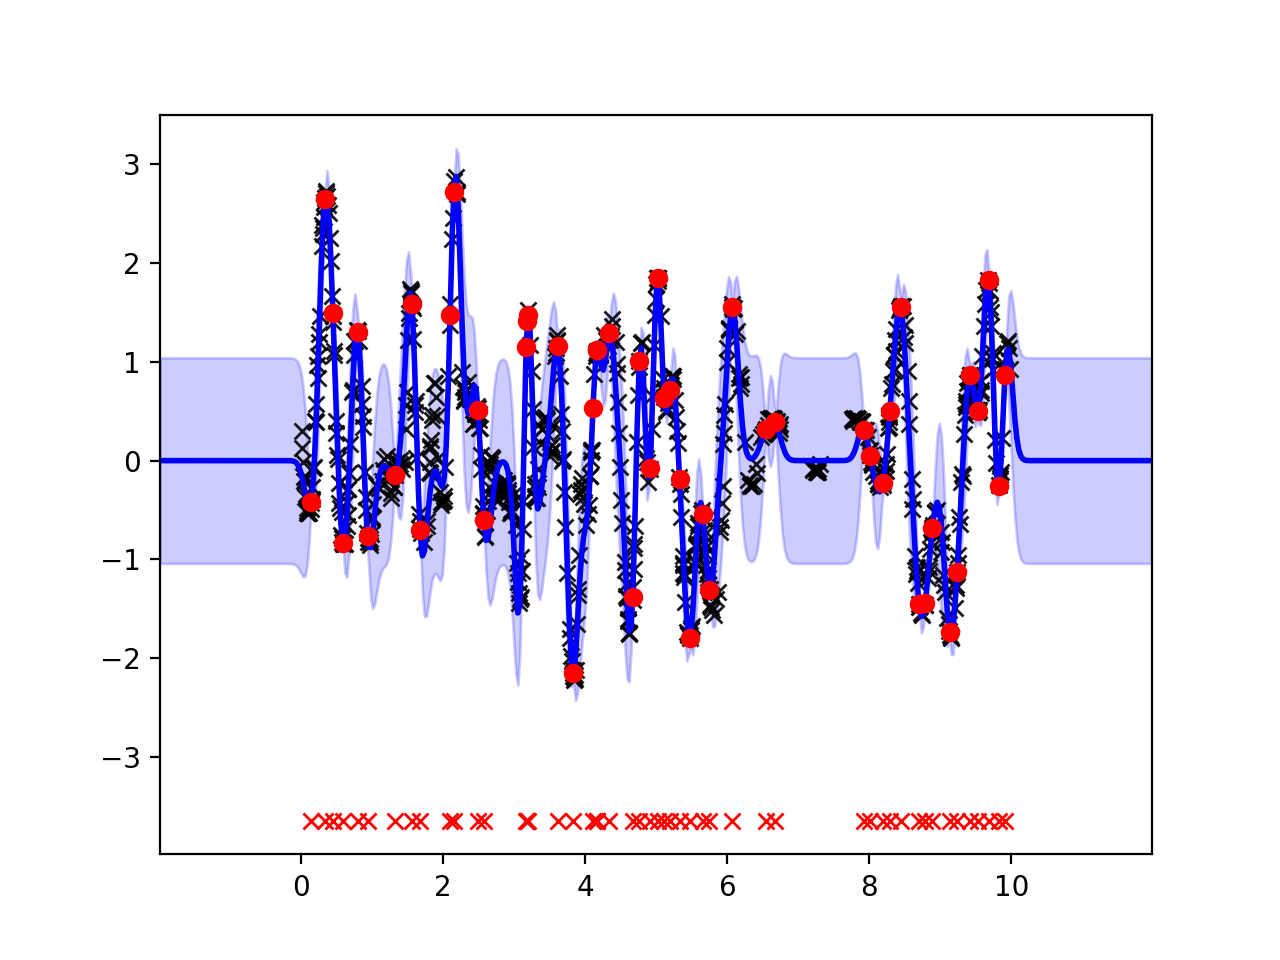

In [53]:
fig = SGP_figures(model_sgp).plot()
plt.show()

Dataset size:  2500  Test size:  1000.0
Training:  750
0.110839310931 0.291944755769


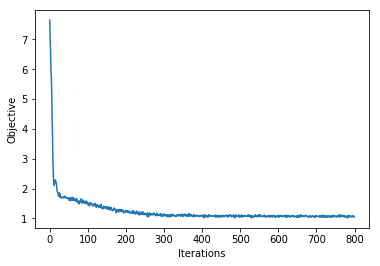

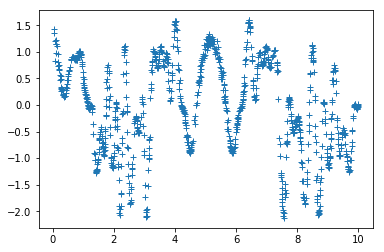

In [5]:
path = 'data/sample_3.txt'
X_train, y_train, X_test, y_test = load_data(path, N_train=750, test=0.4, norm_out=False)
# X_test, y_test = delete_blocks(X_test, y_test,
#                                intervals=[3, 4,5,7])

scores = metrics.METRICS(y_test, model.predict_y(X_test)[0],model.predict_y(X_test)[1])
print scores.mse(), scores.nll()

plt.figure()
plt.plot(X_test, y_test, '+')
plt.show()

In [13]:
scores = metrics.METRICS(y_test, model.predict_y(X_test)[0],model.predict_y(X_test)[1])
print scores.mse(), scores.nll()

0.00654055677351 -1.09848551802


Dataset size:  2500  Test size:  1000.0
Training:  750
Removing blocks... [3, 4, 5, 7]
0.211898128326 0.773450980406


<IPython.core.display.Javascript object>


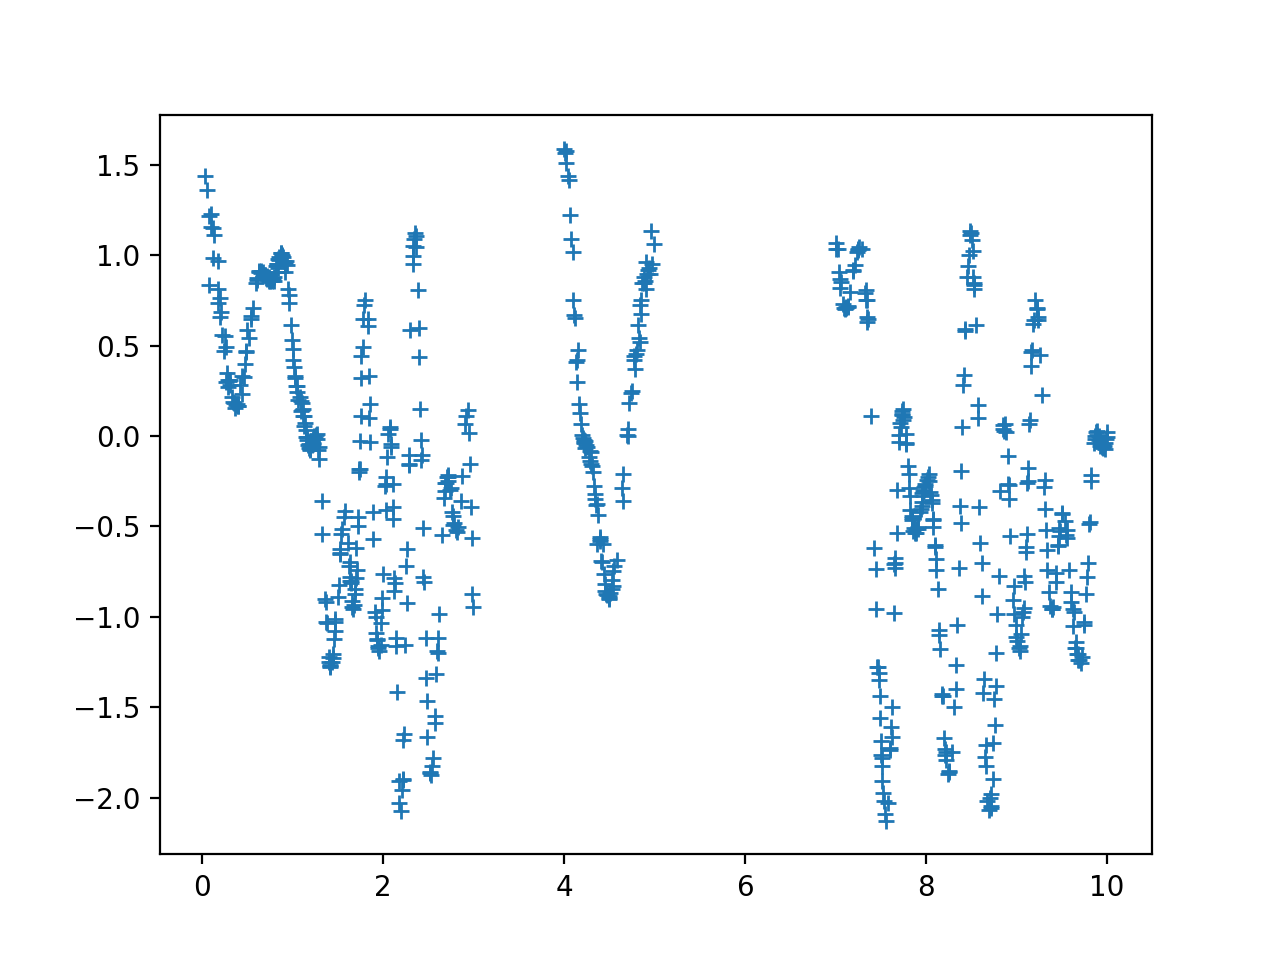

In [28]:
path = 'data/sample_3.txt'
X_train, y_train, X_test, y_test = load_data(path, N_train=750, test=0.4, norm_out=False)
X_test, y_test = delete_blocks(X_test, y_test,
                               intervals=[3, 4,5,7])

scores = metrics.METRICS(y_test, model.predict_y(X_test)[0],model.predict_y(X_test)[1])
print scores.mse(), scores.nll()

plt.figure()
plt.plot(X_test, y_test, '+')
plt.show()

In [27]:
print metrics.METRICS(y_test, model.predict_y(X_test)[0],model.predict_y(X_test)[1]).nll()
print metrics.ho_nll_samples(model, X_test, y_test, N_samples=1000)
print metrics.nll_MLE_samples(model, X_test, y_test, N_samples=1000)

-0.0995343245461
-0.130466297584
-0.104547410096


In [18]:
N_test = X_test.shape[0]
samples = model.sample_f(X_test, no_samples=100).reshape(-1,100)
m = np.mean(samples,axis=1).reshape(-1,1)
v = np.var(samples,axis=1).reshape(-1,1)
sn =  np.exp(2 * model.get_hypers()['sn'])
print np.max(np.abs(model.predict_y(X_test)[1]- ( v + sn * np.ones((N_test,1)))))
print np.max(np.abs(model.predict_y(X_test)[0]- (m)))

0.0938443186145
0.167205417637


In [25]:
A = np.random.rand(2,2)
A = np.eye(2)
theta1 = np.diag([1,-1])

JITTER = 1e-5
val, V = np.linalg.eig(theta1)
D = np.diag(val)
D[D<0] = JITTER
theta1 = V.T * D * V
print theta1.shape

(2, 2)
